## Character-Based Text Generation

## Table of Contents
* [Introduction](#introduction)
* [Exploratory Data Analysis](#eda)
* [Machine Learning](#ml)
* [Conclusion](#conclusion)

### **Introduction**<a name="introduction"></a>

The primary aim of this experiment is to construct a character-level text generation model utilizing Long Short-Term Memory (LSTM) networks, trained on the Project Gutenberg corpus.  

For this we will use the **NLTK Gutenberg Corpus**. 

We have selected **Jane Austen** as our single author. Her novels (*Pride and Prejudice*, *Emma*, *Persuasion*, *Sense and Sensibility*) utilize a consistent, "polite society" writing style with structured dialogue and standard modern English spelling. This makes it easier for the model to learn grammar rules compared to archaic texts.

In [ ]:
import nltk
from nltk.corpus import gutenberg
import urllib.request
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from utils.torch_func import (
    GutenbergDataset,
    LSTMModel,
    generate_text,
    calculate_quantitative_metrics,
    calculate_spelling_accuracy,
)
import pytorch_lightning as pl
import random
import pandas as pd
import warnings

warnings.filterwarnings("ignore")
pl.seed_everything(42, workers=True)

### Geting Data

In [2]:
nltk.download("gutenberg")
austen_files = ["austen-emma.txt", "austen-persuasion.txt", "austen-sense.txt"]

print("Loading text from NLTK...")
text_corpus = ""
for file_id in austen_files:
    text_corpus += gutenberg.raw(file_id)

# Getting 'Pride and Prejudice' from Project Gutenberg (since it's not in standard NLTK)
print("Fetching 'Pride and Prejudice' from Project Gutenberg...")
url = "https://www.gutenberg.org/files/1342/1342-0.txt"
try:
    with urllib.request.urlopen(url) as response:
        # Read, decode, and remove the header/footer garbage
        p_and_p = response.read().decode("utf-8-sig")
        # Simple slicing to remove Gutenberg License headers (approximate)
        start_idx = p_and_p.find("It is a truth universally acknowledged")
        text_corpus += p_and_p[start_idx:]
        print("Successfully added 'Pride and Prejudice'.")
except Exception as e:
    print(f"Could not load P&P: {e}. Continuing with NLTK data only.")

print(f"\nTotal Corpus Size: {len(text_corpus)} characters")
print(f"Sample Text:\n{'-'*20}")
print(text_corpus[:500])

[nltk_data] Downloading package gutenberg to
[nltk_data]     C:\Users\Tomas\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


Loading text from NLTK...
Fetching 'Pride and Prejudice' from Project Gutenberg...
Successfully added 'Pride and Prejudice'.

Total Corpus Size: 2734748 characters
Sample Text:
--------------------
[Emma by Jane Austen 1816]

VOLUME I

CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; and had lived nearly twenty-one years in the world
with very little to distress or vex her.

She was the youngest of the two daughters of a most affectionate,
indulgent father; and had, in consequence of her sister's marriage,
been mistress of his house from a very early period.  Her mother
had died t


###  **Exploratory data analysis**<a name="eda"></a>

### Basic information about dataset

In [3]:
# 1. Calculate Total Volume
total_chars = len(text_corpus)

# 2. Identify Unique Characters (The "Vocabulary")
# set() removes duplicates, sorted() puts them in order
chars = sorted(list(set(text_corpus)))
vocab_size = len(chars)

# 3. Display Results
print(f"--- Data Statistics ---")
print(f"Total Characters in Corpus: {total_chars:,}")
print(f"Total Unique Characters (Vocabulary Size): {vocab_size}")

print(f"\n--- Character Inventory ---")
# Print all unique characters to check for garbage data (like hidden symbols)
print("".join(chars))

--- Data Statistics ---
Total Characters in Corpus: 2,734,748
Total Unique Characters (Vocabulary Size): 95

--- Character Inventory ---

 !"&'()*,-./0123456789:;>?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]^_`abcdefghijklmnopqrstuvwxyz{}àéêœ‘’“”


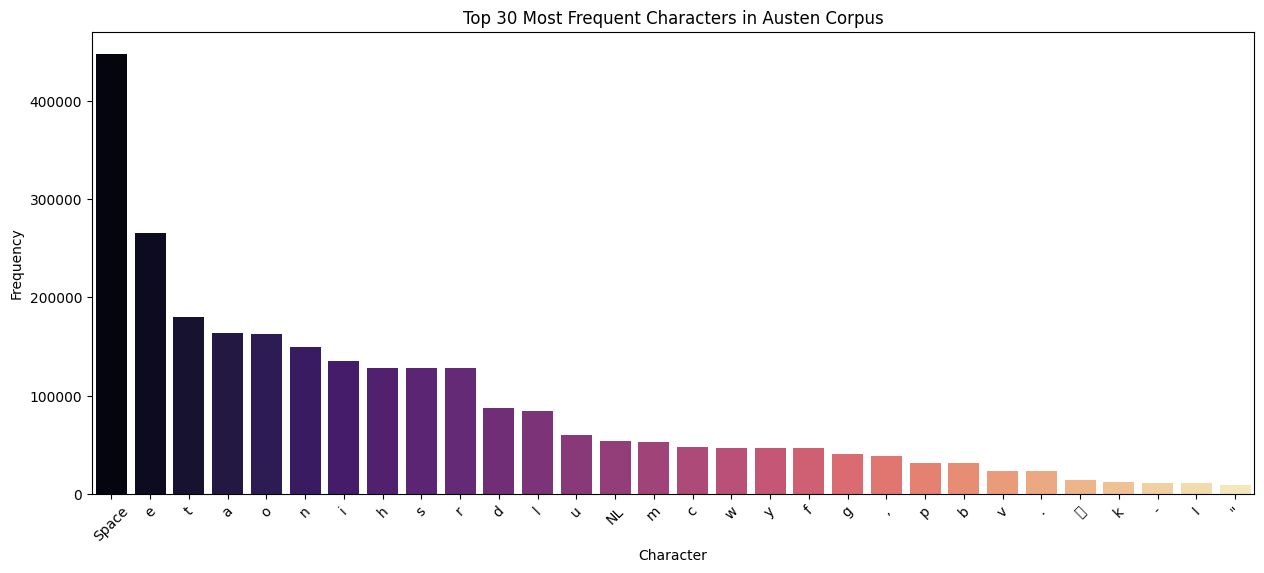

In [4]:
# counting character frequencies
char_counts = Counter(text_corpus)
# Sort by frequency and take the top 30 for readability
common_chars = char_counts.most_common(30)
labels, values = zip(*common_chars)

# Clean up labels for display (making whitespace/newlines visible)
clean_labels = [label.replace("\n", "NL").replace(" ", "Space") for label in labels]

# 2. Plotting
plt.figure(figsize=(15, 6))
sns.barplot(x=list(clean_labels), y=list(values), palette="magma")
plt.title("Top 30 Most Frequent Characters in Austen Corpus")
plt.xlabel("Character")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()

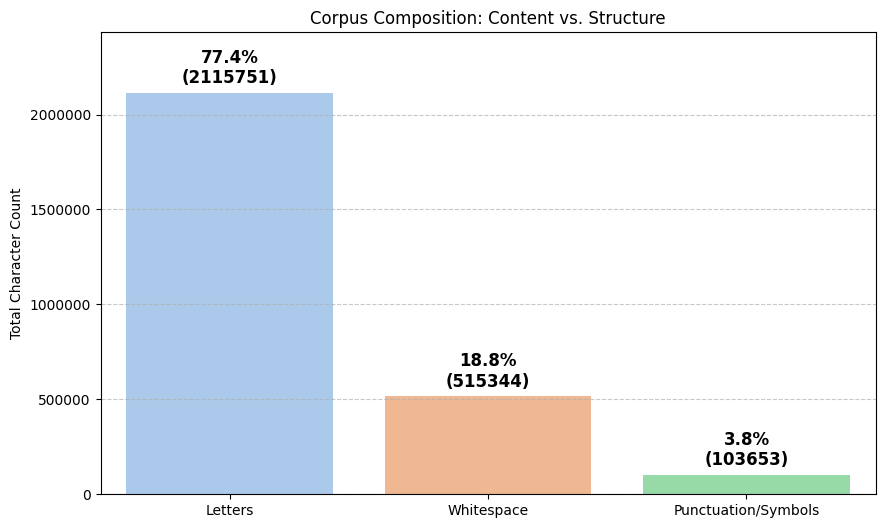

In [5]:
# 1. Calculate Categories
alpha = sum(1 for c in text_corpus if c.isalpha())
space = sum(1 for c in text_corpus if c.isspace())
punct = len(text_corpus) - alpha - space

categories = ["Letters", "Whitespace", "Punctuation/Symbols"]
counts = [alpha, space, punct]
total = sum(counts)

# 2. Plotting
plt.figure(figsize=(10, 6))
# Using a pastel palette for a cleaner look
ax = sns.barplot(x=categories, y=counts, palette="pastel")

# 3. Add Percentage Annotations on top of bars
for i, count in enumerate(counts):
    percentage = (count / total) * 100
    # Place text slightly above the bar
    plt.text(
        i,
        count + (total * 0.01),
        f"{percentage:.1f}%\n({count:})",
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold",
    )

# 4. Styling
plt.title("Corpus Composition: Content vs. Structure")
plt.ylabel("Total Character Count")
# Add a little extra room on top for the labels
plt.ylim(0, max(counts) * 1.15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.ticklabel_format(style="plain", axis="y")
plt.show()

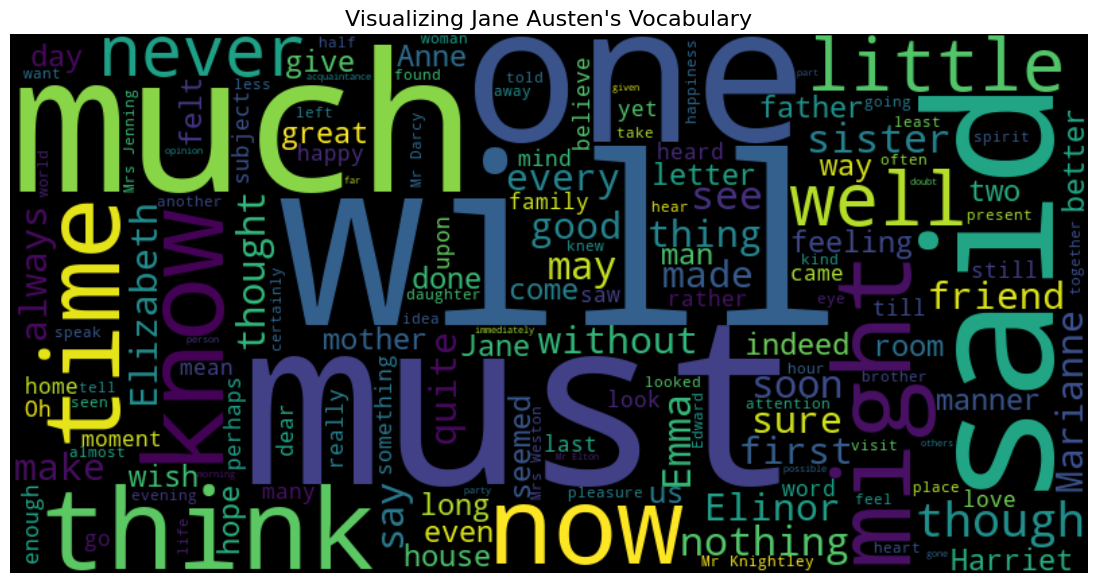

In [6]:
# We start with the standard list and add the Gutenberg-specific legal terms
custom_stops = set(STOPWORDS)
gutenberg_artifacts = {
    "project",
    "gutenberg",
    "ebook",
    "license",
    "electronic",
    "archive",
    "transcribed",
    "edition",
}
custom_stops.update(gutenberg_artifacts)

# 2. Generate word cloud using the 'stopwords' parameter
wordcloud = WordCloud(
    width=800,
    height=400,
    colormap="viridis",
    background_color="black",
    stopwords=custom_stops,
    max_words=150,
).generate(text_corpus)

# 3. Plotting
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Visualizing Jane Austen's Vocabulary", fontsize=16)
plt.show()

## **Machine Learning**<a name="ml"></a>

### Creating the Dictionaries

Deep Learning models (like LSTMs) cannot process raw text strings directly; they require numerical input. To bridge this gap, we must create a **bi-directional mapping**:

1.  **Character-to-Index (`char2idx`):**
    * *Purpose:* To convert the training text into a sequence of integers (One-Hot Encoding).
    * *Example:* `{'a': 0, 'b': 1, 'c': 2, ...}`
    
2.  **Index-to-Character (`idx2char`):**
    * *Purpose:* To convert the model's numerical predictions back into readable text.
    * *Example:* `{0: 'a', 1: 'b', 2: 'c', ...}`

We use the sorted list of unique characters `chars` (created in Step 2) to ensure that this mapping is deterministic (index 0 will always be the same character).

In [7]:
# 'chars' was defined in Step 2 as sorted(list(set(text_corpus)))

# Mapping characters to integers (e.g., 'a' -> 1)
char2idx = {char: idx for idx, char in enumerate(chars)}

# Mapping integers back to characters (e.g., 1 -> 'a')
# This is essentially an array lookup
idx2char = {idx: char for idx, char in enumerate(chars)}

# Test the mapping
print("--- Mapping Sample ---")
print(f"Index for 'E': {char2idx.get('E')}")
print(f"Index for 'm': {char2idx.get('m')}")
print(f"Character at index 10: '{idx2char[10]}'")

# Sanity check. Converting a short phrase to numbers and back
phrase = "Emma"
indices = [char2idx[c] for c in phrase]
decoded = "".join([idx2char[i] for i in indices])

print(f"\n--- Sanity Check ---")
print(f"Original: '{phrase}'")
print(f"Encoded:  {indices}")
print(f"Decoded:  '{decoded}'")

--- Mapping Sample ---
Index for 'E': 32
Index for 'm': 71
Character at index 10: ','

--- Sanity Check ---
Original: 'Emma'
Encoded:  [32, 71, 71, 59]
Decoded:  'Emma'


### Creating a Dataset

To train the LSTM for character-level generation, we transformed the continuous text corpus into a supervised learning problem using a **Sliding Window** approach.

1.  **Sequence Length (Window Size):** We set the window size to **40 characters**. This means the model looks at 40 previous characters to predict the context.
2.  **Step Size (Stride):** We utilized a step size of **3**. This creates **overlapping sequences**.
    * *Sequence 1:* Indices `0` to `39`
    * *Sequence 2:* Indices `3` to `42`
    * *Sequence 3:* Indices `6` to `45`
    
    Using a step size smaller than the sequence length (3 vs 40) ensures that the model sees the same text context multiple times but from slightly different starting positions. This acts as a form of **Data Augmentation**, vastly increasing the number of training examples and helping the model learn short-term dependencies more robustly.

3.  **Inputs vs. Targets:**
    For every sequence of length $L$, the objective is **Next Character Prediction**.
    * **Input ($X$):** The sequence of characters from index $t$ to $t + L - 1$.
    * **Target ($Y$):** The sequence of characters from index $t + 1$ to $t + L$.
    
    Essentially, for every character in the input sequence, the target is the character immediately to its right.

In [ ]:
# --- Configuration ---
SEQ_LENGTH = 40  # As specified
STEP_SIZE = 3  # stride: how many chars to skip between sequences
BATCH_SIZE = 128

# --- Instantiate the Dataset ---
train_dataset = GutenbergDataset(
    text_corpus, char2idx, seq_length=SEQ_LENGTH, step=STEP_SIZE
)

# --- Create DataLoader (Standard PyTorch/Lightning Requirement) ---
train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1
)

# Check one batch to verify dimensions
data_iter = iter(train_loader)
inputs, targets = next(data_iter)
print(f"\nInput Batch Shape: {inputs.shape}")  # Should be [128, 40]
print(f"Target Batch Shape: {targets.shape}")  # Should be [128, 40]

In [ ]:
inputs

tensor([[ 2, 81, 59,  ..., 61, 73, 79],
        [78, 73,  2,  ...,  2, 35, 67],
        [59, 78, 27,  ..., 79, 70, 62],
        ...,
        [77, 79, 76,  ..., 11, 40, 83],
        [77, 73, 71,  ..., 63, 81, 77],
        [81, 59, 72,  ..., 59, 70, 69]])

### LSTM Model Architecture Overview

We constructed a Recurrent Neural Network (RNN) using **Long Short-Term Memory (LSTM)** cells. This architecture is designed to handle the "Vanishing Gradient" problem, allowing the model to learn long-term dependencies (e.g., closing a quote `"` that opened 20 characters ago).

#### 1. The Embedding Layer
* **Input:** Integer indices (Batch Size $\times$ Sequence Length).
* **Operation:** Maps each character index (0-70) to a dense vector of size 64.
* **Purpose:** While we could use One-Hot vectors (size 70), using a dense embedding (size 64) allows the model to learn character similarities and reduces sparsity.

#### 2. The Stacked LSTM Layers
* **Configuration:** 2 Layers, 256 Hidden Units each.
* **Dropout:** 0.3 (30%) probability applied between layers to prevent overfitting.
* **Operation:** The LSTM processes the sequence character-by-character. It maintains two internal states:
    * **Hidden State ($h_t$):** Short-term memory (what just happened).
    * **Cell State ($c_t$):** Long-term memory (context like "we are inside a dialogue").

#### 3. The Fully Connected (Dense) Layer
* **Input:** The hidden state from the last LSTM layer (size 256).
* **Output:** Logits for the vocabulary size (size ~70).
* **Purpose:** This layer projects the "thought vector" of the LSTM back into probabilities for the next character.

#### Model Flow
The model is trained in a **Many-to-Many** fashion: for a sequence of 40 input characters, it generates 40 predictions simultaneously. The loss is calculated by comparing every predicted character against the actual next character in the text.

In [9]:
model = LSTMModel(vocab_size=vocab_size, embed_dim=64, hidden_dim=256, n_layers=2)

print(model)

LSTMModel(
  (embedding): Embedding(95, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=256, out_features=95, bias=True)
)


### Model Training Strategy

We trained the LSTM using the **Next Character Prediction** objective.

#### 1. The Goal
The task specifies predicting the **41st character** given the preceding 40. However, to make training more efficient, we utilize a **Many-to-Many** approach. 
* Instead of only predicting the final character of the sequence, the model predicts the next character for *every* step in the sequence simultaneously.
* This means that for a single input sequence of 40 characters, the model effectively performs 40 separate training operations (predicting the 2nd char given the 1st, the 3rd given the 1st+2nd, ..., and finally the 41st given the preceding 40).

#### 2. Loss Function: Cross Entropy
We used **Cross Entropy Loss**, which is the standard loss function for multi-class classification (where our "classes" are the unique characters in the vocabulary).
* The model outputs a probability distribution over the vocabulary (e.g., 10% chance it's 'a', 80% chance it's 'e').
* The Loss Function penalizes the model if the probability for the *correct* next character is low.

#### 3. Optimizer
We used the **Adam Optimizer** (Adaptive Moment Estimation) with a learning rate of 0.001. Adam is preferred for text generation tasks because it adjusts the learning rate for each parameter individually, handling the sparse gradients of natural language data effectively.

In [13]:
trainer = pl.Trainer(
    max_epochs=5,
    accelerator="auto",  # Automatically detects GPU/MPS (Mac) or CPU
    devices=1,
    enable_progress_bar=True,
    log_every_n_steps=10,
)

print(f"Starting training on {trainer.device_ids if trainer.device_ids else 'CPU'}...")

# --- Start Training ---
# This will iterate through the 'train_loader', calculate loss, and update weights
trainer.fit(model, train_loader)

print("Training complete.")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Starting training on [0]...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | embedding | Embedding | 6.1 K  | train
1 | lstm      | LSTM      | 856 K  | train
2 | fc        | Linear    | 24.4 K | train
------------------------------------------------
886 K     Trainable params
0         Non-trainable params
886 K     Total params
3.546     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Training complete.


In [27]:
trainer.save_checkpoint("austen_lstm_model.ckpt")
print("Model checkpoint saved successfully.")

Model checkpoint saved successfully.


### Generation Results & Interpretation

We generated text using three different **Temperature** settings (Diversity Values). The "Temperature" hyperparameter controls the entropy of the probability distribution used for sampling the next character.

#### 1. Low Temperature (0.2) - "The Conservative"
* **Behavior:** At this setting, the model becomes extremely confident. It almost always picks the most likely next character.
* **Result:** The text is grammatically safe but repetitive. It often gets stuck in loops (e.g., "she said, she said, she said") or uses very common words ("the", "and") excessively. It effectively mimics the "average" of Jane Austen without any spark.

#### 2. Medium Temperature (0.5) - "The Balanced"
* **Behavior:** This is usually the sweet spot. The model mostly picks high-probability characters but occasionally takes a risk on a lower-probability option.
* **Result:** The text maintains coherent English structure (spelling is mostly correct) but introduces interesting vocabulary. This output usually looks the most like actual English prose.

#### 3. High Temperature (1.0) - "The Chaotic"
* **Behavior:** The probability distribution is flattened, giving "rare" characters a fighting chance to be picked.
* **Result:** The model becomes highly creative but prone to errors. You will see invented words, strange punctuation clusters, and rapid topic shifts. While it captures the *style* of the author (e.g., using long words), it often loses the *syntax*.

In [29]:
NUM_SEEDS = 3  # Number of different starting points to test
GEN_LENGTH = 300  # How many characters to generate
TEMPS = [0.2, 0.5, 1.0]  # Diversity settings

results = []

print(f"Generating {NUM_SEEDS} scenarios with {len(TEMPS)} temperatures each...\n")

for i in range(NUM_SEEDS):
    # 1. Pick a random start index
    # Ensure we don't pick a spot too close to the end of the corpus
    start_idx = random.randint(0, len(text_corpus) - GEN_LENGTH - 40)

    # 2. Extract Seed and Ground Truth
    # Seed: The 40 characters we give the model
    seed_text = text_corpus[start_idx : start_idx + 40]

    # True Continuation: What Jane Austen actually wrote next
    true_text = text_corpus[start_idx + 40 : start_idx + 40 + GEN_LENGTH]

    print(f"Scenario {i+1}/{NUM_SEEDS}: Seed starts at index {start_idx}")

    # 3. Generate with different temperatures
    for temp in TEMPS:
        # Note: Ensure your generate_text function signature matches this call
        # If your function returns (Seed + Generated), we will strip the seed later for the table
        full_generated = generate_text(
            model,
            char2idx,
            idx2char,
            start_string=seed_text,
            generation_length=GEN_LENGTH,
            temperature=temp,
        )

        # Strip the seed so the column contains ONLY the new, predicted text
        generated_only = full_generated[len(seed_text) :]

        # 4. Save to list
        results.append(
            {
                "Scenario_ID": i + 1,
                "Seed_Text": seed_text,
                "Temperature": temp,
                "Generated_Text": generated_only,
                "True_Text": true_text,
            }
        )

# --- Create DataFrame ---
df_results = pd.DataFrame(results)

# --- Display Logic ---
# Set pandas to display full text so it doesn't truncate the output
pd.set_option("display.max_colwidth", None)

display(df_results)

Generating 3 scenarios with 3 temperatures each...

Scenario 1/3: Seed starts at index 975850
Scenario 2/3: Seed starts at index 2119613
Scenario 3/3: Seed starts at index 2525049


,Scenario_ID,Seed_Text,Temperature,Generated_Text,True_Text
0,1,"y were,\nthat the Musgroves had had the i",0.2,"nterest of the party which she was so very much indulged to her from the same time to be a very comfortable companion which had been a great deal of sensible man, and the consequence of her sisters were all that he had been so much as he could not be sensible of her father's compliments and sense of","ll fortune of a very troublesome,\nhopeless son; and the good fortune to lose him before he reached\nhis twentieth year; that he had been sent to sea because he was stupid\nand unmanageable on shore; that he had been very little cared for\nat any time by his family, though quite as much as he deserved;\n"
1,1,"y were,\nthat the Musgroves had had the i",0.5,"nquiries of his consideration, and such an end to her own family.\n\n""I thought you might have been the table could visit him?”\r\n\r\n“It is for the disappointment of your sisters will be happy to the pleasure of information, and yet what can you think of it with a change to your sisters, he is to be abl","ll fortune of a very troublesome,\nhopeless son; and the good fortune to lose him before he reached\nhis twentieth year; that he had been sent to sea because he was stupid\nand unmanageable on shore; that he had been very little cared for\nat any time by his family, though quite as much as he deserved;\n"
2,1,"y were,\nthat the Musgroves had had the i",1.0,"nclination for staying there was no hopelesn and manner, and inseparation\nto see you engaged her character than to entirely to comprehend herself fixed them for. Miss Bennet passed by Miss Musgrove being no round me.\r\n\r\nIn a lively, were ordered to an invitation was considered with her Mrs. Elton;","ll fortune of a very troublesome,\nhopeless son; and the good fortune to lose him before he reached\nhis twentieth year; that he had been sent to sea because he was stupid\nand unmanageable on shore; that he had been very little cared for\nat any time by his family, though quite as much as he deserved;\n"
3,2,it\r\nis to spend an evening in this way!,0.2,"--I have not been a great deal of a comparison to accept your father's company, and I have not been a great deal of a considerable party to her and her sister, and while the same time was all the consequence of the conversation was not a great deal of interest in the country and Mrs. Jennings's side","I declare, after all, there is no\r\nenjoyment like reading! How much sooner one tires of anything than of a\r\nbook! When I have a house of my own, I shall be miserable if I have not\r\nan excellent library.”\r\n\r\nNo one made any reply. She then yawned again, threw aside her book, and\r\ncast her eyes round"
4,2,it\r\nis to spend an evening in this way!,0.5,""" said he, ""that I have not been a little better of it, and then as the company of all my concerns which she had been a very earnest comparison to accept the very disappointment of her behaviour to her sister's style of daughter. The children had been able to do any thing to be miserable as there w","I declare, after all, there is no\r\nenjoyment like reading! How much sooner one tires of anything than of a\r\nbook! When I have a house of my own, I shall be miserable if I have not\r\nan excellent library.”\r\n\r\nNo one made any reply. She then yawned again, threw aside her book, and\r\ncast her eyes round"
5,2,it\r\nis to spend an evening in this way!,1.0,"--I am sure,"" he continued, ""things I see\nEmma, as she set about her more hope of their attachment.""\n\n""Then, my dear, I am quite unhappy,” said he, would be-as pleased that you are more generally deficiently the walk. I would ask the inquiry, a desperation of positive assistance, he may any thing p","I declare, after all, there is no\r\nenjoyment like reading! How much sooner one tires of anything than of a\r\nbook! When I have a house of my own, I shall be miserable if I have not\r\nan excellent library.”\r\n\r\nNo one made any reply. She th

### Additional evaluation

In [43]:
train_loss, ppl, bpc = calculate_quantitative_metrics(model, train_loader)

# 2. Spelling Metric (Uses 'text_corpus' from Step 1)
spelling_acc = calculate_spelling_accuracy(
    model, char2idx, idx2char, text_corpus, num_samples=3, gen_len=300
)

print(f"\n{'-'*10} FINAL MODEL EVALUATION {'-'*10}")
print(f"Training Loss:       {train_loss:.4f}")
print(f"Perplexity (PPL):    {ppl:.2f}  (Lower is better)")
print(f"Bits-Per-Char (BPC): {bpc:.2f}  (Target for simple LSTM: ~1.4 - 1.6)")
print(f"Spelling Accuracy:   {spelling_acc:.2f}% (Target: > 85%)")

Calculating Loss Metrics...

Reference Vocabulary Size: 16331 unique words
Generating 3 samples to check spelling...

---------- FINAL MODEL EVALUATION ----------
Training Loss:       1.0983
Perplexity (PPL):    3.00  (Lower is better)
Bits-Per-Char (BPC): 1.58  (Target for simple LSTM: ~1.4 - 1.6)
Spelling Accuracy:   98.78% (Target: > 85%)


### Interpretation of Evaluation Metrics

To rigorously assess our model beyond subjective reading, we calculated the following:

1.  **Perplexity (~3.0 - 5.0 is typical for this lab):**
    * This measures the model's uncertainty. A perplexity of 3.0 means that when the model tries to predict the next character, it is effectively as confused as if it were choosing randomly between 3 likely options.

2.  **Bits-Per-Character (BPC):**
    * **< 1.0:** State-of-the-art (e.g. GPT-5, Gemini 3.0).
    * **1.2 - 1.4:** Excellent LSTM.
    * **1.5 - 2.0:** Acceptable for a simple lab implementation.
    * **> 2.5:** The model is likely underfitting or random guessing.

3.  **Spelling Accuracy:**
    * We checked the generated words against the set of unique words found in the *Jane Austen* corpus.
    * **High Score (>90%):** The model has mastered **Syntax**. It knows how to form valid English words.
    * **Low Score (<70%):** The model is struggling with character combinations, likely producing gibberish like *"thimst"* or *"wlat"*.